In [181]:
import pandas as pd
import numpy as np
import matplotlib as nlp
import matplotlib.pyplot as plt
import re
import nltk
import glob
import seaborn as sns
import string
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import gensim
from gensim.models import Word2Vec, KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
import plotly.express as px
import plotly.graph_objs as go
import plotly.offline as pyo
from plotly.subplots import make_subplots
from sklearn.naive_bayes import ComplementNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from math import *
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import train_test_split
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer
nltk.download('punkt')
nltk.download('stopwords')
plt.rc('figure',figsize=(17,13))
sns.set_style('darkgrid')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [182]:
#read file
from google.colab import drive
drive.mount('/content/drive')
df_tweets = pd.read_csv("/content/drive/MyDrive/tweets/World Cup 2022 Influencer Tweets.csv")
# Initialize the VADER sentiment analyzer
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()
# Initialize the Word2Vec model
path = "/content/drive/MyDrive/tweets/GoogleNews-vectors-negative300.bin"
model = KeyedVectors.load_word2vec_format(path, binary=True, limit=20000000)
#display the first tweets
df_tweets.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,user_name,user_location,user_created,user_followers,user_favourites,user_verified,date,text,source
0,FIFA World Cup,NaN,2010-04-29 10:58:07+00:00,12329448,2228,True,2023-01-18 16:02:30+00:00,The greatest final ever. \n\n#FIFAWorldCup | #...,Twitter for Advertisers
1,beIN SPORTS,MENA,2012-05-10 13:45:16+00:00,1440770,5828,True,2023-01-18 15:39:50+00:00,🗓️🏆\n\nOne month on from a truly 𝙪𝙣𝙛𝙤𝙧𝙜𝙚𝙩𝙩𝙖𝙗𝙡𝙚...,Twitter Web App
2,FIFA World Cup,NaN,2010-04-29 10:58:07+00:00,12329448,2228,True,2023-01-18 11:30:30+00:00,"“Argentine Gold!” 🫶\n\nA month ago today, Ange...",Twitter for Advertisers
3,Road to 2022,NaN,2016-02-29 12:02:29+00:00,1296410,877,True,2023-01-17 12:16:17+00:00,The #Qatar2022 Podium: \n\n🥇 @Argentina \n🥈 @F...,Twitter for iPhone
4,Road to 2022,NaN,2016-02-29 12:02:29+00:00,1298433,877,True,2023-01-17 12:16:17+00:00,The #Qatar2022 Podium: \n\n🥇 @Argentina \n🥈 @F...,Twitter for iPhone


# Dropping columns

In [183]:
columns=df_tweets.columns
columns

Index(['user_name', 'user_location', 'user_created', 'user_followers',
       'user_favourites', 'user_verified', 'date', 'text', 'source'],
      dtype='object')

In [184]:
df_tweets.drop(['user_location','user_created','user_favourites','date','source'],axis=1,inplace=True)
df_tweets.head()

,user_name,user_followers,user_verified,text
0,FIFA World Cup,12329448,True,The greatest final ever. \n\n#FIFAWorldCup | #...
1,beIN SPORTS,1440770,True,🗓️🏆\n\nOne month on from a truly 𝙪𝙣𝙛𝙤𝙧𝙜𝙚𝙩𝙩𝙖𝙗𝙡𝙚...
2,FIFA World Cup,12329448,True,"“Argentine Gold!” 🫶\n\nA month ago today, Ange..."
3,Road to 2022,1296410,True,The #Qatar2022 Podium: \n\n🥇 @Argentina \n🥈 @F...
4,Road to 2022,1298433,True,The #Qatar2022 Podium: \n\n🥇 @Argentina \n🥈 @F...


#clearing duplicates

In [185]:
df_tweets.drop_duplicates(subset='text',inplace=True)
df_tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 987 entries, 0 to 987
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   user_name       987 non-null    object
 1   user_followers  987 non-null    int64 
 2   user_verified   987 non-null    bool  
 3   text            987 non-null    object
dtypes: bool(1), int64(1), object(2)
memory usage: 31.8+ KB


#deep cleaning

In [186]:
#replace all NaN values wit an empty string
df_tweets = df_tweets.replace(np.nan, '')
df_tweets.shape
# function for twitter text cleaning
def tweet_cleaner(text):
    #remove RT
    text = re.sub("RT @[\w]*:","",text)
    #remove twitter handles (@user)
    text = re.sub("(@[A-Za-z0-9_]+)","", text)
    #remove url links
    text = re.sub("https?://[A-Za-z0-9./]*","",text)
    # remove whitespaces
    text = ' '.join(text.split())
    return text
#Apply text cleaning function to text column in tweets dataframe
df_tweets['text'] = df_tweets['text'].apply(lambda x:tweet_cleaner(x))
df_tweets.shape

(987, 4)

In [187]:
#removing shortwords
df_tweets['text']= df_tweets['text'].apply(lambda x: " ".join([w for w in x.split() if len(w)>2]))
df_tweets.head(5)

,user_name,user_followers,user_verified,text
0,FIFA World Cup,12329448,True,The greatest final ever. #FIFAWorldCup #Qatar2022
1,beIN SPORTS,1440770,True,🗓️🏆 One month from truly 𝙪𝙣𝙛𝙤𝙧𝙜𝙚𝙩𝙩𝙖𝙗𝙡𝙚 FIFA Wo...
2,FIFA World Cup,12329448,True,"“Argentine Gold!” month ago today, Angel Maria..."
3,Road to 2022,1296410,True,The #Qatar2022 Podium:
5,FIFA World Cup,12326652,True,Another step forward #Qatar2022 🏴󠁧󠁢󠁥󠁮󠁧󠁿 Gareth...


In [188]:
# Define a function to calculate sentiment using VADER and Word2Vec models
def get_sentiment(text):
    # Tokenize the text and remove stop words
    tokens = [word.lower() for word in nltk.word_tokenize(text) if word.isalpha() and word.lower() not in nltk.corpus.stopwords.words('english')]
    
    # Calculate sentiment using VADER
    vader_score = sia.polarity_scores(text)['compound']
    
    # Calculate sentiment using Word2Vec
    if len(tokens) > 0:
        w2v_score = sum([model[word].sum() if word in model.key_to_index else 0 for word in tokens]) / len(tokens)
    else:
        w2v_score = 0
    
    # Combine the two scores using a weighted average
    sentiment_score = 0.7 * vader_score + 0.3 * w2v_score
    
    # Classify the sentiment based on the score
    if sentiment_score >= 0.5:
        sentiment = 'Positive'
    elif sentiment_score <= -0.5:
        sentiment = 'Negative'
    else:
        sentiment = 'Neutral'
    
    return sentiment

# Apply the sentiment analysis function to the dataframe
df_tweets['Sentiment'] = df_tweets['text'].apply(get_sentiment)

# Print the resulting dataframe
#print(df)

In [189]:
df_tweets.head(5)

,user_name,user_followers,user_verified,text,Sentiment
0,FIFA World Cup,12329448,True,The greatest final ever. #FIFAWorldCup #Qatar2022,Neutral
1,beIN SPORTS,1440770,True,🗓️🏆 One month from truly 𝙪𝙣𝙛𝙤𝙧𝙜𝙚𝙩𝙩𝙖𝙗𝙡𝙚 FIFA Wo...,Neutral
2,FIFA World Cup,12329448,True,"“Argentine Gold!” month ago today, Angel Maria...",Neutral
3,Road to 2022,1296410,True,The #Qatar2022 Podium:,Negative
5,FIFA World Cup,12326652,True,Another step forward #Qatar2022 🏴󠁧󠁢󠁥󠁮󠁧󠁿 Gareth...,Neutral


# REMOVING PUNCTUATIONS AND MAKING TEXT LOWERCASE

In [190]:
def clean_text(text):
    
    text = str(text).lower()
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    
    return text
df_tweets['text'] = df_tweets['text'].apply(lambda x:clean_text(x))
df_tweets['text']

0         the greatest final ever fifaworldcup qatar2022
1      🗓️🏆 one month from truly 𝙪𝙣𝙛𝙤𝙧𝙜𝙚𝙩𝙩𝙖𝙗𝙡𝙚 fifa wo...
2      “argentine gold” month ago today angel maria a...
3                                   the qatar2022 podium
5      another step forward qatar2022 🏴󠁧󠁢󠁥󠁮󠁧󠁿 gareth ...
                             ...                        
983    qatar had swallow 20 defeat ecuador the 2022 w...
984    ecuador won 20 against qatar despite the bribe...
985    brilliant game ecuador very well deserving win...
986    breaking ecuador marks the first victory qatar...
987    video saudi crown prince mohammed bin salman s...
Name: text, Length: 987, dtype: object

# Sentiment Count

In [191]:
temp = df_tweets.groupby('Sentiment').count()['text'].reset_index().sort_values(by='text',ascending=False)
temp.style.background_gradient(cmap='Purples')

,Sentiment,text
1,Neutral,440
2,Positive,348
0,Negative,199


# FUNNEL CHART FOR BETTER VISUALIZATION OF SENTIMENT DISTRIBUTION

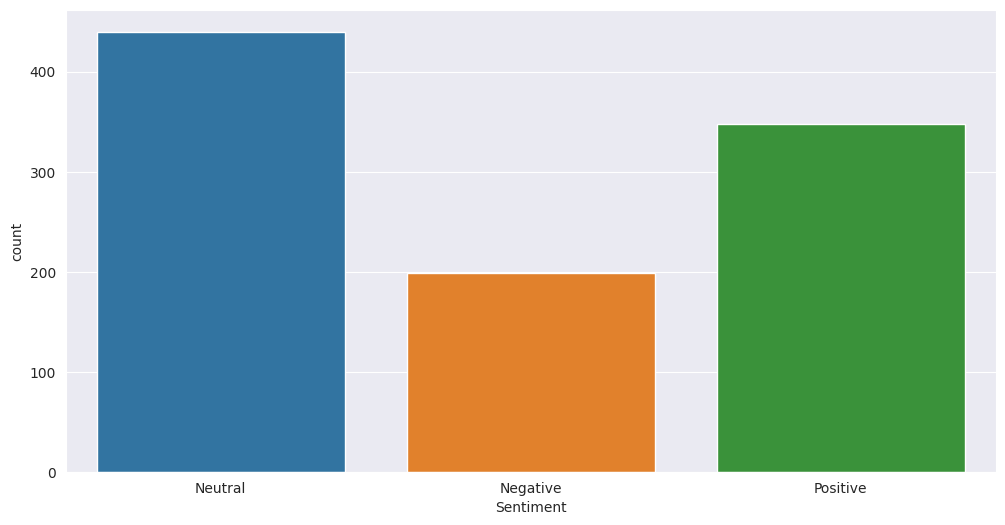

In [192]:
plt.figure(figsize=(12,6))
sns.countplot(x='Sentiment',data=df_tweets)
fig = go.Figure(go.Funnelarea(
    text = temp.Sentiment,
    values = temp.text,
    title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}
    ))
fig.show()

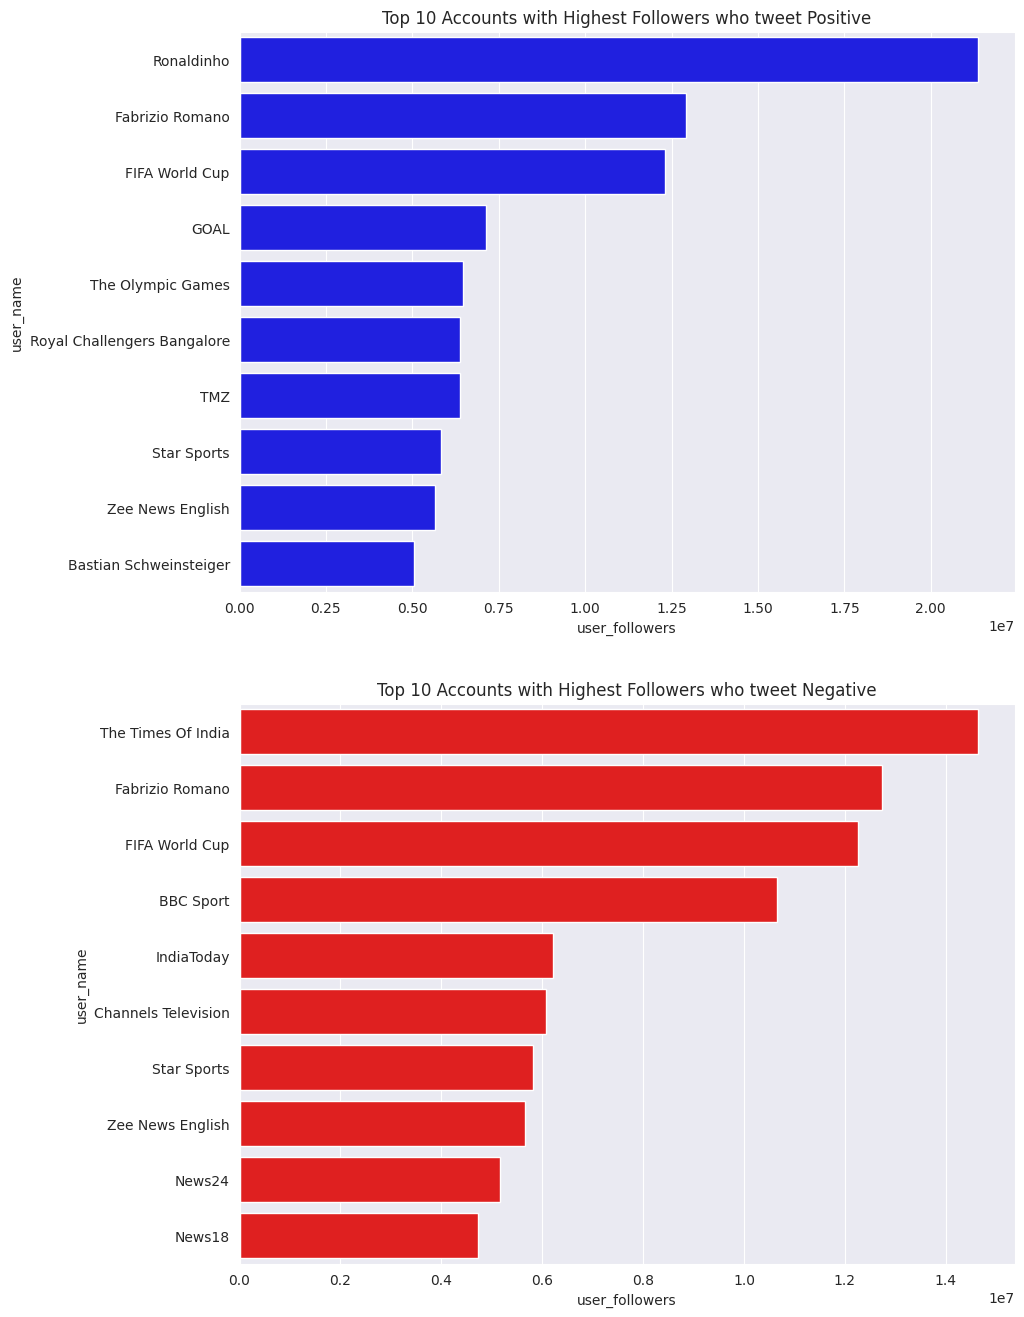

In [193]:
from matplotlib import rcParams

fig, (ax1, ax3) = plt.subplots(2,1, figsize=(10, 16))
sns.barplot(x="user_followers", y="user_name", orient="h", ax=ax1, palette=["b"],
           data=df_tweets[(df_tweets.Sentiment== "Positive")]\
           .drop_duplicates(subset=["user_name"])\
           .sort_values(by=["user_followers"], ascending=False)[["user_name", "user_followers"]][:10])
ax1.set_title('Top 10 Accounts with Highest Followers who tweet Positive')

sns.barplot(x="user_followers", y="user_name", orient="h", ax=ax3, palette=["r"],
           data=df_tweets[(df_tweets.Sentiment == "Negative")]
           .drop_duplicates(subset=["user_name"])\
           .sort_values(by=["user_followers"], ascending=False)[["user_name", "user_followers"]][:10])
ax3.set_title('Top 10 Accounts with Highest Followers who tweet Negative')

fig.show()

# Checking Model Accuracy

In [194]:
y=df_tweets['Sentiment']
df_tweets = df_tweets.replace(['Positive','Neutral','Negative'],[2, 1, 0])
df_tweets.head()

,user_name,user_followers,user_verified,text,Sentiment
0,FIFA World Cup,12329448,True,the greatest final ever fifaworldcup qatar2022,1
1,beIN SPORTS,1440770,True,🗓️🏆 one month from truly 𝙪𝙣𝙛𝙤𝙧𝙜𝙚𝙩𝙩𝙖𝙗𝙡𝙚 fifa wo...,1
2,FIFA World Cup,12329448,True,“argentine gold” month ago today angel maria a...,1
3,Road to 2022,1296410,True,the qatar2022 podium,0
5,FIFA World Cup,12326652,True,another step forward qatar2022 🏴󠁧󠁢󠁥󠁮󠁧󠁿 gareth ...,1


In [199]:
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv = CountVectorizer(stop_words='english',ngram_range = (1,1),tokenizer = token.tokenize)
text_counts = cv.fit_transform(df_tweets['text'].values.astype('U'))
X=text_counts
y=df_tweets['Sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,random_state=19)
cnb = ComplementNB()
cnb.fit(X_train, y_train)
cross_cnb = cross_val_score(cnb, X, y,n_jobs = -1)
print("Cross Validation score = ",cross_cnb)                
print ("Train accuracy ={:.2f}%".format(cnb.score(X_train,y_train)*100))
print ("Test accuracy ={:.2f}%".format(cnb.score(X_test,y_test)*100))
train_acc_cnb=cnb.score(X_train,y_train)
test_acc_cnb=cnb.score(X_test,y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



Cross Validation score =  [0.41414141 0.4040404  0.37563452 0.35532995 0.4213198 ]
Train accuracy =93.92%
Test accuracy =43.43%


In [196]:
from sklearn.metrics import *
#Predict test data set
y_pred_cnb =cnb.predict(X_test)

#This is the confusion matrix :
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test,y_pred_cnb))

[[18 20  5]
 [34 44 18]
 [14 21 24]]


In [197]:
#Checking performance our model with classification report
print(classification_report(y_test, y_pred_cnb))

              precision    recall  f1-score   support

           0       0.27      0.42      0.33        43
           1       0.52      0.46      0.49        96
           2       0.51      0.41      0.45        59

    accuracy                           0.43       198
   macro avg       0.43      0.43      0.42       198
weighted avg       0.46      0.43      0.44       198



In [198]:
from sklearn.metrics import *

print("F1 score ={:.2f}%".format(f1_score(y_test, y_pred_cnb, average="macro")*100))
f1_cnb=f1_score(y_test, y_pred_cnb, average="macro")
print("Precision score ={:.2f}%".format(precision_score(y_test, y_pred_cnb, average="macro")*100))
precision_cnb=precision_score(y_test, y_pred_cnb, average="macro")
print("Recall score ={:.2f}%".format(recall_score(y_test, y_pred_cnb, average="macro")*100))  
recall_cnb=recall_score(y_test, y_pred_cnb, average="macro")

F1 score =42.31%
Precision score =43.37%
Recall score =42.79%
